# Machine Learning



In [1]:
# Import required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set()

In [2]:
# Read the previous csv file as dataframe
df = pd.read_csv('data.csv').drop(['Unnamed: 0'],axis=1)
df.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day
0,2010-12-01,10002,60,51.00,48,2,1
1,2010-12-01,10125,2,1.70,48,2,1
2,2010-12-01,10133,5,4.25,48,2,1
3,2010-12-01,15044B,1,2.95,48,2,1
4,2010-12-01,15056BL,20,113.00,48,2,1


#### Our final dataset is ready to carry out machine learning operations.

## Machine Learning Process and Methodology

To find the best model for our purpose, we will train our data on different algorithms, compare their performance based on the Root mean square error of the prediction and time taken to fit/predict the model, and select the best. 

### Algorithms employed:
1. Linear Regression
2. Regularization Model - Ridge
3. Regularization Model - Lasso
4. Ensemble Model - Random Forest
1. Ensemble Model - Gradient Boost
1. Ensemble Model - Ada Boost

After training and evaluating our data on the above algorithms, we will also use model stacking.

7. Stack - Linear Regression
8. Stack - Random Forest
9. Stack - Gradient Boost

### Train-test split

We will hold out the data for last month from Nov-01-2011 to Dec-09-2011 as our test set, and the remaining data will be used to train our model.

In [3]:
# Split the dataset into train and test dataset

df_train = df[df.InvoiceDate<'2011-11-01']
df_test = df[df.InvoiceDate>='2011-11-01']

In [4]:
df_train.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day
0,2010-12-01,10002,60,51.00,48,2,1
1,2010-12-01,10125,2,1.70,48,2,1
2,2010-12-01,10133,5,4.25,48,2,1
3,2010-12-01,15044B,1,2.95,48,2,1
4,2010-12-01,15056BL,20,113.00,48,2,1


In [5]:
# Define the feature and target variables

X_train = df_train.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_train = df_train.Quantity

X_test = df_test.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_test = df_test.Quantity

In [6]:
# Data Frame to store all the RMSE scores for various algorithms
algo_score = pd.DataFrame()
algo_score.index.name = 'Modelling Algo'
algo_score['Train RMSE'] = None
algo_score['Test RMSE'] = None
algo_score['Hyperparameters'] = None
algo_score['Training+Test Time(sec)'] = None

cv_time = []

# Dataframes for second level of predictions. Collect the predicted y values for training and test set of data
ypred_train = pd.DataFrame(index = X_train.index)
ypred_test = pd.DataFrame(index = X_test.index)

ypred_train['quantity'], ypred_test['quantity'] = y_train, y_test


We will define functions to measure the model, apply cross validation, and predict on train and test datasets. We have not included model fitting in the functions as that will happen as part of hyperparameter tuning

In [7]:
from sklearn.metrics import make_scorer

# Metric used to measure the model (Root Mean Square Error)
def rmse(y_actual, y_pred):
    rmse = np.sqrt(mean_squared_error(y_actual,y_pred))
    return rmse
rmse_cv = make_scorer(rmse, greater_is_better=False)

plot_true_vs_pred: This is used to plot True and Predicted count values for a particular time interval



In [8]:
# Plots True vs. Predicted count values
def plot_true_vs_pred (y_actual, y_pred):
    fig = plt.figure(figsize=(18, 16))
    
    pred_val = pd.DataFrame({'actual':y_actual,'predicted':y_pred})
    pred_val['error']=abs(pred_val.actual-pred_val.predicted)
    sns.swarmplot(pred_val.actual.round(0),pred_val.error)
    
    plt.show()

In [9]:
# Function to predict on train and test data and return the required metrics
def model_fit(model, X_train, y_train, X_test, y_test):
    ''' 
    Input:
        model = model to be applied
        X_train y_train = Training data
        X_test, y_test = Testing data
    Output:
        rmse for training and test data 
        predicted y for training and test data
    
    '''
#     model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    rmse_train = rmse(y_train, y_train_predict)
    rmse_test = rmse(y_test, y_test_predict)
    
    rmse_all = [rmse_train, rmse_test]
    y_pred_all = [y_train_predict, y_test_predict]
    
    return(rmse_all, y_pred_all)

In [10]:
from sklearn.model_selection import cross_val_predict
def cross_val(model, X_train, y_train, cv=5):
#     y_pred = pd.Series(index=y_train.index)
    y_pred = cross_val_predict(model,X_train,y_train,cv=5)

    rmse_train = rmse(y_train,y_pred)
    return(rmse_train, y_pred)


## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

param_summary = ['','']

%time reg.fit(X_train, y_train)
%time rmse_summary, y_predict_summary = model_fit(reg, X_train, y_train, X_test, y_test)

ypred_test['LR'] = y_predict_summary[1]  
ypred_train['LR'] = y_predict_summary[0]

algo_score.loc['Linear Regression'] = rmse_summary+param_summary

CPU times: total: 0 ns
Wall time: 17.6 ms
CPU times: total: 0 ns
Wall time: 11.5 ms


In [12]:
algo_score.loc['Linear Regression', 'Training+Test Time(sec)'] = 0.516
cv_time.append(0.516)
algo_score

,Train RMSE,Test RMSE,Hyperparameters,Training+Test Time(sec)
Modelling Algo,,,,
Linear Regression,25.431848,26.443285,,0.516


#### Observations

Not an overfit model - both train and test RMSE are more or less similar

In [69]:
import joblib
joblib.dump(reg, 'Linear_regresssion.pkl')

['Linear_regresssion.pkl']

In [13]:
# Features and the Estimated Linear Regression Coefficients
df_coeff = pd.DataFrame({'features': X_train.columns, 'Lin_Coeff': reg.coef_})

In [14]:
# Linear Regression Plot: True vs. Predicted
# plot_true_vs_pred(y_test,y_predict_summary[1])

### Regularization Model - Ridge


In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time ridge.fit(X_train, y_train)
print('Best alpha for Ridge Regression Model: {}'.format(ridge.best_params_))

CPU times: total: 281 ms
Wall time: 2.03 s
Best alpha for Ridge Regression Model: {'alpha': 100}


In [16]:
# Fine tune Hyperparameter for edge cases
param_grid = {'alpha': np.arange(75,150,10)}
ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time ridge.fit(X_train, y_train)
print('Best alpha for Ridge Regression Model: {}'.format(ridge.best_params_))

CPU times: total: 531 ms
Wall time: 3.1 s
Best alpha for Ridge Regression Model: {'alpha': 145}


In [17]:
param_summary = [ridge.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(ridge, X_train, y_train, X_test, y_test)

ypred_test['Ridge'] = y_predict_summary[1]  
ypred_train['Ridge'] = y_predict_summary[0]

algo_score.loc['Ridge Regression'] = rmse_summary+param_summary

CPU times: total: 0 ns
Wall time: 24.4 ms


In [18]:
algo_score.loc['Ridge Regression', 'Training+Test Time(sec)'] = 6.917
cv_time.append(6.917)
algo_score

,Train RMSE,Test RMSE,Hyperparameters,Training+Test Time(sec)
Modelling Algo,,,,
Linear Regression,25.431848,26.443285,,0.516
Ridge Regression,25.431848,26.443280,{'alpha': 145},6.917


#### Observations

Ridge gives almost similar performance as Linear Regression. It is not an overfit model

In [70]:
joblib.dump(ridge, 'Ridge_Regression.pkl')

['Ridge_Regression.pkl']

In [19]:
# Features and the Estimated Ridge Regression Coefficients
df_coeff['Ridge_Coeff'] = ridge.best_estimator_.coef_


In [20]:
# plot_true_vs_pred(y_test,y_predict_summary[1])


### Regularization Model - Lasso

In [21]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
lasso = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time lasso.fit(X_train, y_train)
print('Best alpha for Lasso Regression Model: {}'.format(lasso.best_params_))

CPU times: total: 1min 24s
Wall time: 1min 13s
Best alpha for Lasso Regression Model: {'alpha': 0.1}


In [22]:
# Fine tune Hyperparameter for edge case

param_grid = {'alpha': np.arange(.01,.25,.01)}
lasso = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time lasso.fit(X_train, y_train)
print('Best alpha for Lasso Regression Model: {}'.format(lasso.best_params_))

CPU times: total: 2min 28s
Wall time: 1min 54s
Best alpha for Lasso Regression Model: {'alpha': 0.01}


In [23]:
param_summary = [lasso.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(lasso, X_train, y_train, X_test, y_test)
ypred_test['Lasso'] = y_predict_summary[1]
ypred_train['Lasso'] = y_predict_summary[0]

algo_score.loc['Lasso Regression'] = rmse_summary+param_summary

CPU times: total: 15.6 ms
Wall time: 20.3 ms


In [24]:
algo_score.loc['Lasso Regression', 'Training+Test Time(sec)'] = 31.328
cv_time.append(31.328)
algo_score

,Train RMSE,Test RMSE,Hyperparameters,Training+Test Time(sec)
Modelling Algo,,,,
Linear Regression,25.431848,26.443285,,0.516
Ridge Regression,25.431848,26.443280,{'alpha': 145},6.917
Lasso Regression,25.431848,26.443164,{'alpha': 0.01},31.328


#### Observations

Lasso regression also shows almost similar performance as Linear and Ridge regression

In [71]:
joblib.dump(lasso, 'lasso_Regression.pkl')

['lasso_Regression.pkl']

In [25]:
# Features and the Estimated Lasso Regression Coefficients
df_coeff['Lasso_Coeff'] = lasso.best_estimator_.coef_


In [26]:
# plot_true_vs_pred(y_test,y_predict_summary[1])


### Plotting the coefficients obtained from Linear, Ridge and Lasso regression

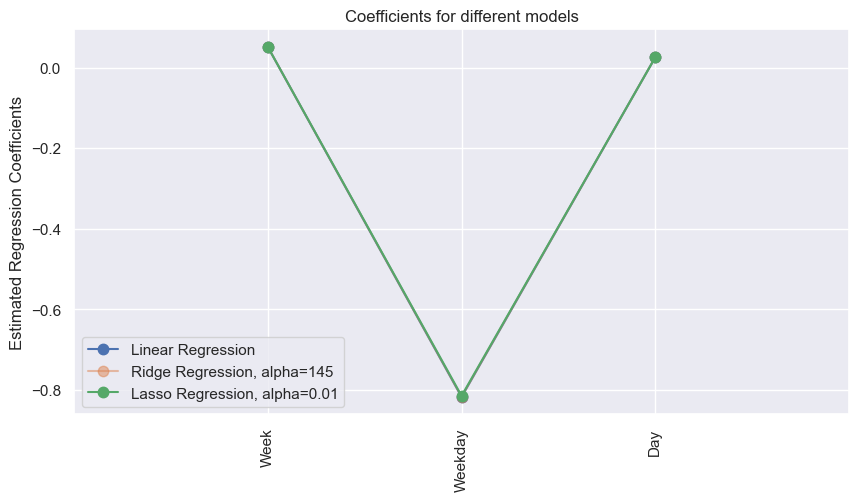

In [27]:
fig = plt.figure(figsize=(10, 5))

axes = fig.add_subplot(1, 1, 1)
axes.plot(df_coeff.Lin_Coeff, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff, label='Ridge Regression, alpha={}'.format(ridge.best_params_['alpha']), alpha=.5,marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff, label='Lasso Regression, alpha={}'.format(lasso.best_params_['alpha']), marker='.', markersize=15)

plt.xticks(range(len(df_coeff.Lin_Coeff)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for different models')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff)])
axes.legend()


#### Observations

As seen above, Weekday and UnitPrice are most important features

### Ensemble Model - Random Forest


In [28]:
# Random Forest Regression Hyperparameter tuning using Grid Search to obtain the best parameters. 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Example of parameter grid with correct max_features values
param_grid = {
    'max_features': ['sqrt', 'log2', None]  # Change 'auto' to valid options
}

# Set up RandomizedSearchCV
model = RandomForestRegressor()
rf_main = RandomizedSearchCV(model, param_grid, n_iter=10, random_state=42)
rf_main.fit(X_train, y_train)


C:\Users\sairi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_features': ['sqrt', 'log2', None]},
                   random_state=42)

In [46]:
# Fit the RandomizedSearchCV object
# Make sure fit() is called before accessing best_params_

# Now access the best_params_
print('Best parameters for Random Forest Regression Model: {}'.format(rf_main.best_params_))


Best parameters for Random Forest Regression Model: {'max_features': 'log2'}


Best parameters for Random Forest Regression Model: {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 50, 'max_features': 'auto'}

In [47]:
param_summary = [rf_main.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(rf_main, X_train, y_train, X_test, y_test)
ypred_test['RF'] = y_predict_summary[1]
ypred_train['RF'] = y_predict_summary[0]

algo_score.loc['Random Forest'] = rmse_summary+param_summary


CPU times: total: 594 ms
Wall time: 1.46 s


In [48]:
algo_score.loc['Random Forest', 'Training+Test Time(sec)'] = 6706
cv_time.append(6706)
algo_score

,Train RMSE,Test RMSE,Hyperparameters,Training+Test Time(sec)
Modelling Algo,,,,
Linear Regression,25.431848,26.443285,,0.516
Ridge Regression,25.431848,26.443280,{'alpha': 145},6.917
Lasso Regression,25.431848,26.443164,{'alpha': 0.01},31.328
Random Forest,25.110594,26.461514,{'max_features': 'log2'},6706


In [72]:
joblib.dump(rf_main, 'Random_Forest.pkl')

['Random_Forest.pkl']

### Visualize the mean score against different values for n estimators

Parts of code have been commenting out as they take long time to execute

In [49]:
rf_result=pd.DataFrame(rf_main.cv_results_)
rf_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.041045,0.178584,0.171981,0.018504,sqrt,{'max_features': 'sqrt'},0.004017,-0.010982,0.005855,0.002172,0.012283,0.002669,0.007629,2
1,4.063665,0.234066,0.194964,0.049845,log2,{'max_features': 'log2'},0.003917,-0.007702,0.006169,0.001324,0.011453,0.003032,0.006319,1
2,6.686024,0.106637,0.178107,0.022362,None,{'max_features': None},-0.011954,-0.001945,0.000951,-0.002351,0.009518,-0.001156,0.006885,3


In [53]:
rf_result.columns


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [57]:

#est_score = rf_result.groupby('params')['mean_test_score'].mean()
#est_score

[Text(0.5, 0, 'n_estimators'),
 Text(0, 0.5, 'Mean CV Test Score'),
 Text(0.5, 1.0, 'n_estimators vs. Score (best_n_estimator = 500)')]

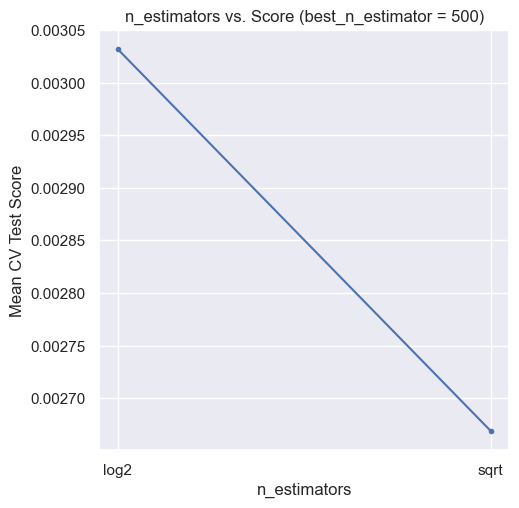

In [58]:
fig=plt.figure(figsize=(18, 12))

axes=fig.add_subplot(2, 3, 1)
axes.plot(est_score.index, est_score.values, marker='.')
axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')


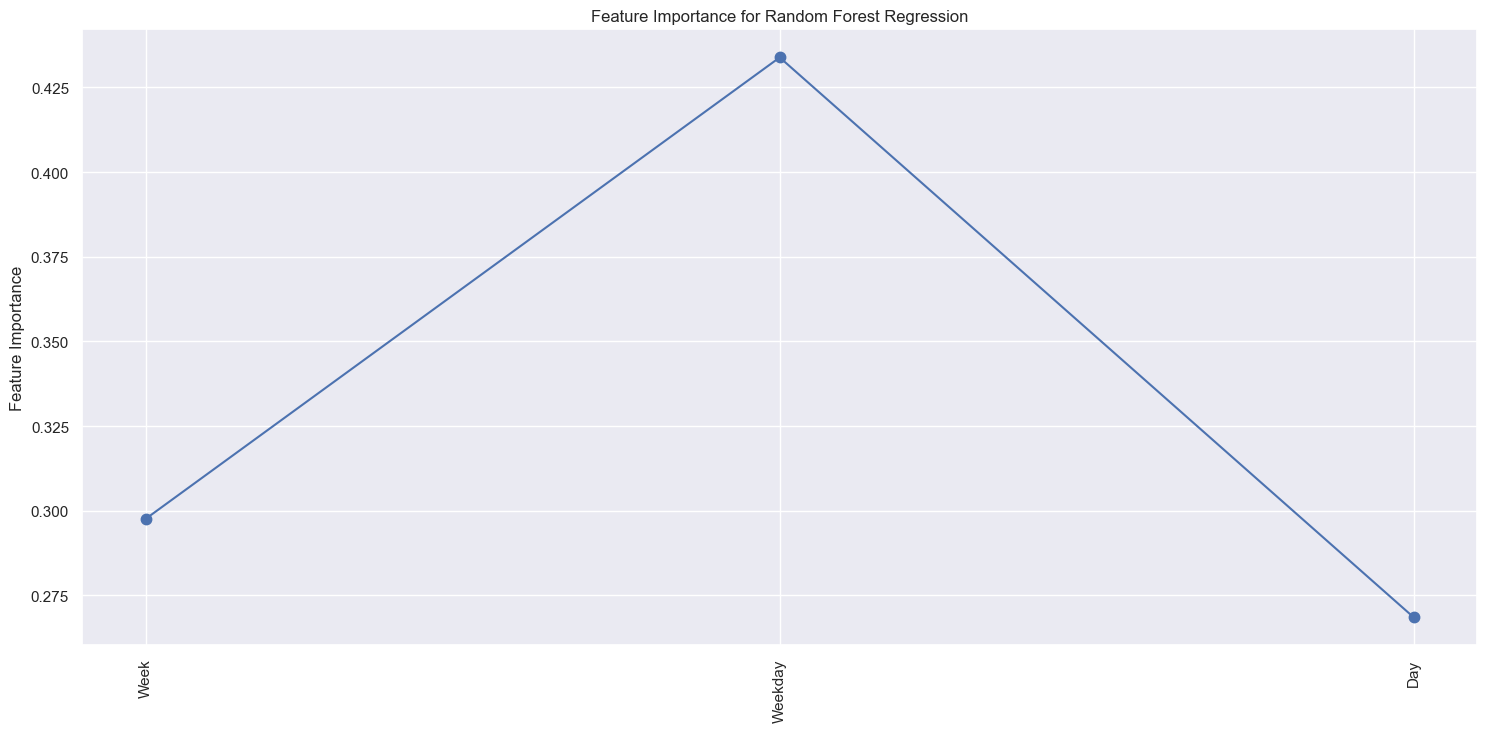

In [59]:
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rf_main.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rf_main.best_estimator_.feature_importances_)), X_train.columns,rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression')

plt.show()


### Ensemble Method - Gradient Boost

In [66]:
# The code for hyperparameter tuning is commented out as it takes a long time to run 

# Tuning the hyperparameters

from sklearn.ensemble import GradientBoostingRegressor

param_distributions = param_distributions = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_features': ['sqrt', 'log2', None],  # Corrected value for max_features
    'min_samples_leaf': [1, 3, 7, 10],
    'min_samples_split': [2, 5, 10]
}

grad_boost = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions, verbose=2, n_iter = 100,cv=5, scoring=rmse_cv)
grad_boost.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.01, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  38.2s
[CV] END learning_rate=0.01, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  37.2s
[CV] END learning_rate=0.01, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  36.5s
[CV] END learning_rate=0.01, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  37.5s
[CV] END learning_rate=0.01, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  38.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.1, max_features=log2

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 3, 7, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 500, 1000]},
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                   verbose=2)

[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=7, max_features=auto, learning_rate=0.01, total=  10.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1, total=   9.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1, total=   5.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1, total=   3.3s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.1, total=   3.1s
[CV] n_estimato

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05, total=   3.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05, total=   3.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05, total=   3.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.05, total=   3.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.01, total=   7.1s
[CV

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.01, total= 1.4min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=3, max_features=auto, learning_rate=0.01, total= 1.5min
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01, total=   6.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01, total=   6.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, learning_rate=0.01, total=   

[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05, total= 1.4min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05, total= 1.2min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05, total= 1.4min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05, total= 1.2min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=0.05 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, learning_rate=

[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=7, max_features=auto, learning_rate=0.1, total=   6.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=7, max_features=auto, learning_rate=0.1 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=7, max_features=auto, learning_rate=0.1, total=   6.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01, total=   7.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01, total=   7.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=auto, learning_rate=0.01, total=  1

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 479.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_features': ['auto'], 'min_samples_leaf': [1, 3, 7, 10], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [74]:
joblib.dump(grad_boost, 'Gradient_Boost.pkl')

['Gradient_Boost.pkl']

In [67]:
print('Best parameters for Gradient Boost Model: {}'.format(grad_boost.best_params_))

Best parameters for Gradient Boost Model: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None, 'learning_rate': 0.05}


Best parameters for Gradient Boost Model: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 60, 'learning_rate': 0.01}

In [75]:
print('Best parameters for Gradient Boost Model: {}'.format(grad_boost.best_params_))

Best parameters for Gradient Boost Model: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None, 'learning_rate': 0.05}


In [76]:
param_summary = [grad_boost.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(grad_boost, X_train, y_train, X_test, y_test)
ypred_test['GB'] = y_predict_summary[1]
ypred_train['GB'] = y_predict_summary[0]

algo_score.loc['Gradient Boost'] = rmse_summary+param_summary

CPU times: total: 141 ms
Wall time: 217 ms


In [77]:
algo_score.loc['Gradient Boost', 'Training+Test Time(sec)'] = 89.796
cv_time.append(89.796)
algo_score

,Train RMSE,Test RMSE,Hyperparameters,Training+Test Time(sec)
Modelling Algo,,,,
Linear Regression,25.431848,26.443285,,0.516
Ridge Regression,25.431848,26.443280,{'alpha': 145},6.917
Lasso Regression,25.431848,26.443164,{'alpha': 0.01},31.328
Random Forest,25.110594,26.461514,{'max_features': 'log2'},6706
Gradient Boost,25.293174,26.409518,"{'n_estimators': 50, 'min_samples_split': 10, ...",89.796


### Visualize the mean score against different values for n estimators

Parts of code have been commenting out as they take long time to execute

In [78]:
gb_result=pd.DataFrame(grad_boost.cv_results_)

gb_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,37.366526,0.646623,0.272761,0.023202,1000,10,7,None,0.01,"{'n_estimators': 1000, 'min_samples_split': 10...",-24.878224,-25.121402,-25.900920,-26.057396,-25.966904,-25.584969,0.486471,70
1,1.083404,0.050434,0.025226,0.007626,50,10,10,log2,0.10,"{'n_estimators': 50, 'min_samples_split': 10, ...",-24.734232,-24.510940,-25.873687,-26.027632,-25.895692,-25.408437,0.647662,29
2,22.471037,1.147340,0.284616,0.027144,1000,10,7,log2,0.01,"{'n_estimators': 1000, 'min_samples_split': 10...",-24.773817,-24.680725,-25.886458,-26.032236,-25.941920,-25.463031,0.603264,52
3,19.124963,0.535475,0.148457,0.022276,500,10,7,None,0.10,"{'n_estimators': 500, 'min_samples_split': 10,...",-25.045715,-25.328906,-25.978312,-26.101427,-26.074682,-25.705809,0.434653,92
4,23.601581,1.223229,0.270978,0.021822,1000,10,3,log2,0.10,"{'n_estimators': 1000, 'min_samples_split': 10...",-24.977668,-25.291101,-26.010637,-26.108467,-26.083961,-25.694367,0.468950,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1439.682079,2835.668028,0.264304,0.012902,1000,5,7,sqrt,0.01,"{'n_estimators': 1000, 'min_samples_split': 5,...",-24.773817,-24.680725,-25.886458,-26.032236,-25.941920,-25.463031,0.603264,52
96,35.957788,1.530764,0.270874,0.024746,1000,5,7,None,0.05,"{'n_estimators': 1000, 'min_samples_split': 5,...",-25.072802,-25.477441,-25.974915,-26.103022,-26.068880,-25.739412,0.402299,96
97,303.651676,584.342758,0.142687,0.016584,500,2,10,sqrt,0.10,"{'n_estimators': 500, 'min_samples_split': 2, ...",-24.950809,-25.213767,-25.974307,-26.075526,-26.016560,-25.646194,0.468979,78
98,35.928264,1.435853,0.273551,0.021501,1000,5,10,None,0.05,"{'n_estimators': 1000, 'min_samples_split': 5,...",-25.072802,-25.477441,-25.974915,-26.103022,-26.068880,-25.739412,0.402299,96


In [ ]:
# gb_score = gb_result.groupby('param_n_estimators')['mean_test_score'].mean()
# gb_score

In [ ]:
# fig=plt.figure(figsize=(18, 12))

# axes=fig.add_subplot(2, 3, 1)
# axes.plot(gb_score.index, gb_score.values, marker='.')
# axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')


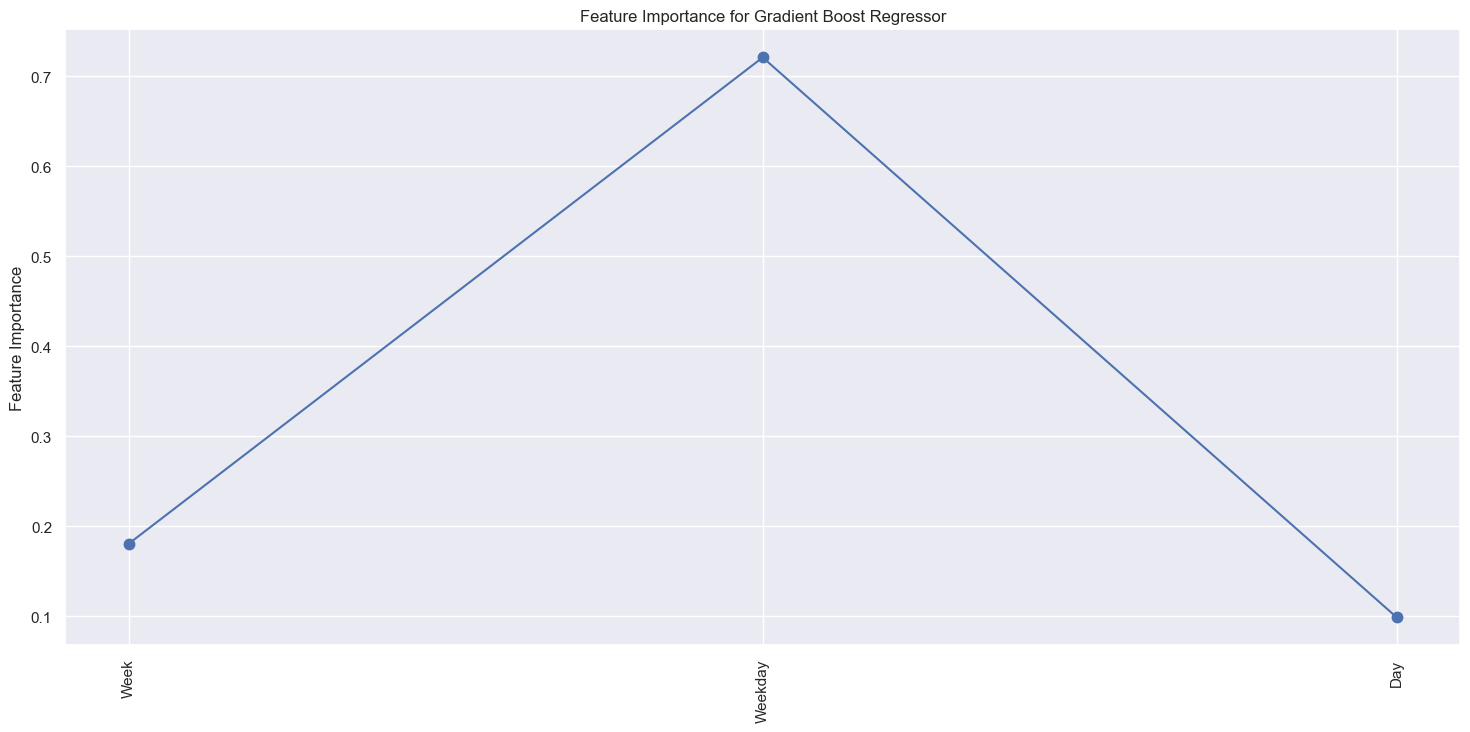

In [79]:
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(grad_boost.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(grad_boost.best_estimator_.feature_importances_)), X_train.columns,rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Gradient Boost Regressor')
# axes.set(xlim=[-1, len(X_train.columns)], ylim=[0, 1])

plt.show()

## SUMMARY AND CONCLUSIONS

### RMSE

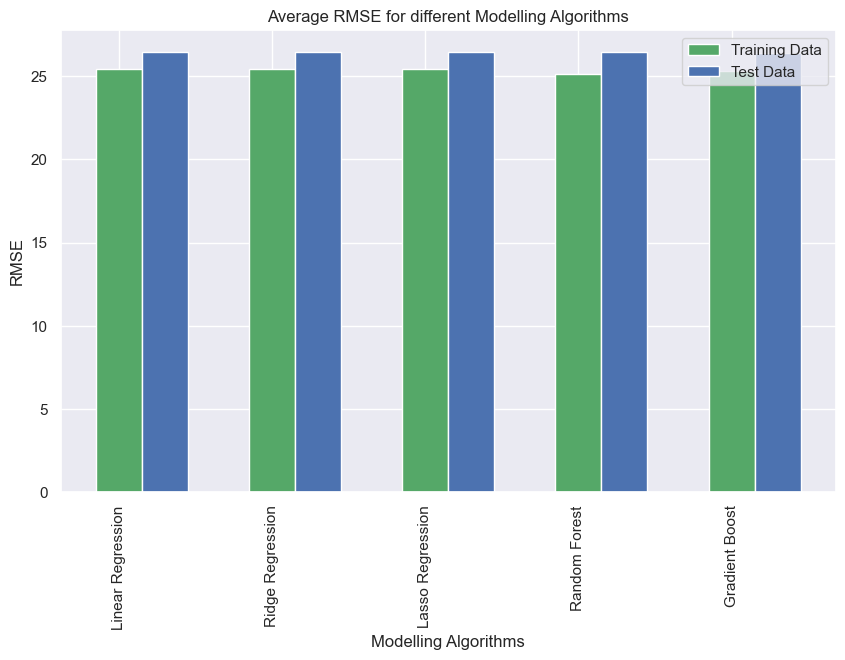

In [80]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Train RMSE', x=idx, color='g', width=bar_width, label='Training Data')
plt.bar(data=algo_score, height='Test RMSE', x=idx+bar_width, color='b', width=bar_width, label='Test Data')
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('RMSE')
plt.title('Average RMSE for different Modelling Algorithms')
plt.legend()
plt.show()

From the above plot, we can see that Random Forest and Gradient Boost give us very similar and the best predictions with least RMSE. Comparing the train and test data predictions, the model seems to be be overfitted. But we are not much worried about it, as despite overfitting, we are getting good results on the test data.

In order to decide between Random Forest and Gradient Boost, let us look at the time taken in fitting the model. In all the algorithms, the prediction time was very small in comparison to the fit time.

### Train/Test Time

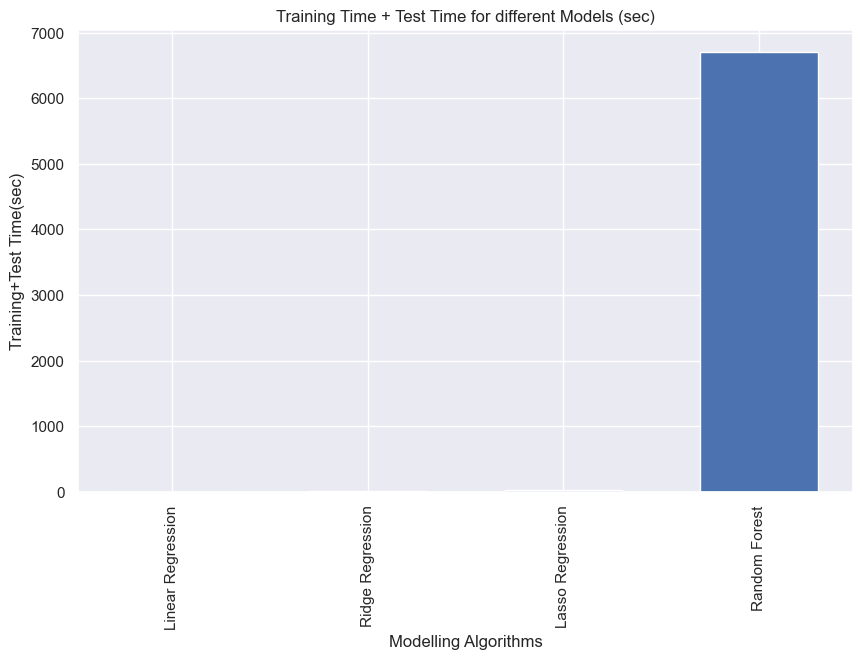

In [63]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.6
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Training+Test Time(sec)', x=idx, width=bar_width)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('Training+Test Time(sec)')
plt.title('Training Time + Test Time for different Models (sec)')
#axes.set_yscale('log')

plt.show()

As seen above, Gradient Boost is taking much lesser time as compared to Random Forest. So we choose Gradient Boost as our final algorithm. 
Gradient Boost gives an RMSE of 0.625 on our test data.

References:

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74